# Laboratory work  3

**Обработка бинарных изображений. Морфология.**

Completed: гр.№ 6131-010402D, Griaznov Ilia <br/>
Variant № 6

In [1]:
import operator
import random
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt
import itertools
import itertools

from warnings import filterwarnings
from IPython.display import clear_output
from matplotlib.pyplot import *
from tqdm.notebook import tqdm
from matplotlib.pylab import *
from collections import defaultdict
import time
from itertools import product
filterwarnings('ignore')
%matplotlib inline

# Лабораторная работа №3
## Обработка бинарных изображений. Морфология.

1. Создать средствами OpenCV бинарное изображение с простым рисунком.
  *   Русунок из простых фигур: квадрат, круг и т.д.
2. Зашумить изображение импульсным шумом с вероятностью p (по вариантам).
  *   Вход: изображение из пункта 1
  *   Вывод: зашумленное изображение
3. Написать функции реализации эрозии и дилатации 

> Функции вида fun(Image, struct)  
Где struct  - структурный элемент в виде матрицы 

4. Выполнить операции эрозии и дилатации для зашумленного изображения со структурным элементом заданным по вариантам.
  *   Вход: изображение из пункта 2
  *   Вывод: Исходное (из пункта 1), зашумленное (из пункта 2) и  изображения после эрозии и дилатации.
5. Отфильтровать зашумленное изображение при помощи морфологических операций вскрытия и закрытия (структурный элемент задан по вариантам).  
Подсчитать коэффициент шума для результа фильтрации.
  *   Вход: изображение из пункта 2
  *   Вывод:  исходное (из пункта 1), зашумленное (из пункта 2) и  изображения после вскрытия и закрытия. Коэффициент шума.
  *   Коэффициент шума считать как количество несовпавших пикселей между отфильтрованным изображением и исходным (не зашумленным) из пункта 1.

6. Отфильтровать изображение при помощи логического фильтра. Подсчитать коэффициент шума для результа фильтрации.
  *   Вход: изображение из пункта 2
  *   Вывод: исходное (из пункта 1), зашумленное (из пункта 2) и отфильтрованное изображение. Коэффициент шума.
  *   Коэффициент шума считать как количество несовпавших пикселей между отфильтрованным изображением и исходным (не зашумленным) из пункта 1.
  *   Таблица логического фильтра в лекции слайд 17.

7. На исходном изображении  с помощью морфологических операций выделить контур объекта. Выяснить, когда контур получается внешним, внутренним, четырёхсвязным, восьмисвязным.
  *   Вход: изображение из пункта 1
  *   Вывод: исходное изображение, изображение с выделенными контурами.

8. На исходном изображении  с помощью морфологических операций выделить горизонтальные и вертикальные контуры объекта. 
  *   Вход: изображение из пункта 1
  *   Вывод: исходное изображение, изображение с выделенными горизонтальными контурами, изображение с выделенными вертикальными контурами.

  
    
    
*Для работы с изображением использовать OpenCV (открытие, сохранение и т.д.). Для визуализации можно использовать matplotlib. Все необходимые для задания функции реализовавать самим, а не использовать готовые в OpenCV, если не указано обратного.*

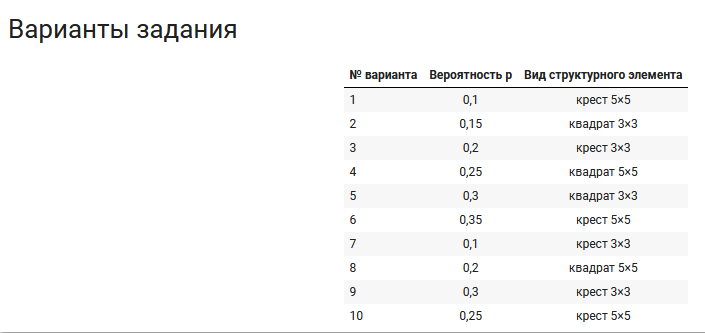

In [2]:
p = 0.1 # Вероятность 

# Крест 5x5 соглачно варианту
сross = np.array([
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [1, 1, 1, 1, 1],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
])

In [3]:
def show_me(image): # вывести изображение 
    figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(image, cmap='gray')


### 1. Создать средствами OpenCV бинарное изображение с простым рисунком.

(200, 200)

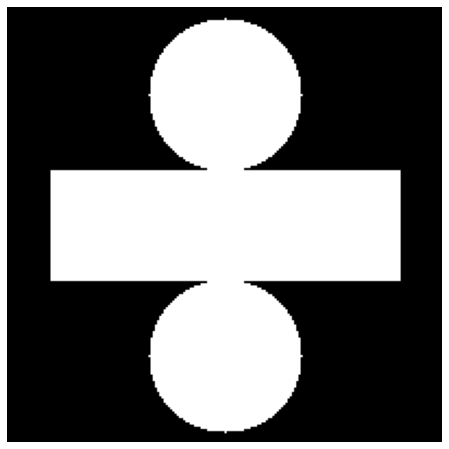

In [4]:
img = np.zeros([200, 200], np.uint8)# Задали размерность

cv2.circle(img, (100, 40), 35, (255, 255, 255), -1)  # Круг
cv2.rectangle(img, (180, 75), (20, 125), (255, 255, 255), -1) # Прямоугольник
cv2.circle(img, (100, 160), 35, (255, 255, 255), -1) # Круг

show_me(img)
img.shape

### 2. Зашумить изображение импульсным шумом с вероятностью p (по вариантам).

In [5]:
def noise(image, p): # Функция для импульсного зашумления
    result = image.copy() 
    r, col = image.shape    
    for i in list(product(range(r), range(col))):
        if np.random.random() <= p:
            result[i[0], i[1]] = 255

    return result

Вывод: зашумленное изображение:
_______________________________


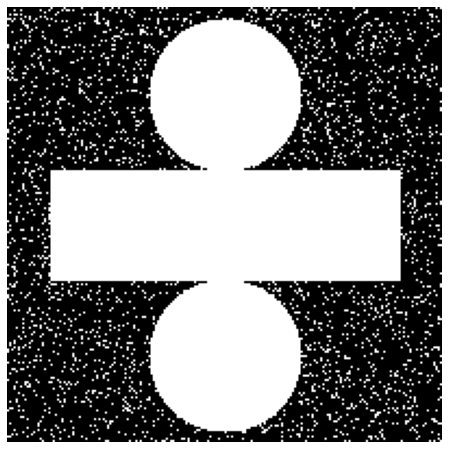

In [6]:
noise_image = noise(img,  p )
print('Вывод: зашумленное изображение:')
print('_______________________________')
show_me(noise_image)

### 3. Написать функции реализации эрозии и дилатации

In [7]:
def give_me(window, kernel): # функция подсчета значений из скользящего окна по заданнному кресту
    vals = []
    k_r, k_c = kernel.shape

    for i, j in np.ndindex((k_r, k_c)):
        if kernel[i, j] == 1:
            vals.append(window[i, j])

    return vals

In [8]:
def eros(img, kernel): # Функция эрозии
    img_r, img_c = img.shape
    kernel_rows, kernel_cols = kernel.shape
    
    
    # создаем пустой массив нулей размером больше изображения на + размер выходящего за пределы окна
    temp_img = np.zeros(
        (img_r + 2 * (kernel_rows // 2), img_c + 2 * (kernel_cols // 2)))
    
    
    # Копируем в него временно наше изображение 
    temp_img[
        (kernel_rows // 2): img_r + 2 * (kernel_rows // 2) - (kernel_rows // 2),
        (kernel_cols // 2): img_c + 2 * (kernel_cols // 2) - (kernel_cols // 2)
    ] = img
    
    
    out = img.copy() #Создаем копию нашей картинки для выходного значения 

    # Далее бежим по всем пикселям нашего изображения и заменяем на минимальное значение из "округи" согласно нашего ядра
    for i, j in tqdm(np.ndindex((img_r, img_c))):
        window = temp_img[i: i + kernel_rows, j: j + kernel_cols]
        out[i, j] = np.min(give_me(window, kernel)) # тут подставлеяем мин

    clear_output()
    return out

In [9]:
def dilat(img, kernel): # Функция эрозии

    img_r, img_c = img.shape
    kernel_rows, kernel_cols = kernel.shape
    
    # создаем пустой массив нулей размером больше изображения на + размер выходящего за пределы окна
    temp_img = np.zeros(
        (img_r + 2 * (kernel_rows // 2), img_c + 2 * (kernel_cols // 2)))
    
    # Копируем в него временно наше изображение 
    temp_img[
        (kernel_rows // 2): img_r + 2 * (kernel_rows // 2) - (kernel_rows // 2),
        (kernel_cols // 2): img_c + 2 * (kernel_cols // 2) - (kernel_cols // 2)
    ] = img
    
    
    out = img.copy() #Создаем копию нашей картинки для выходного значения 

     # Далее бежим по всем пикселям нашего изображения и заменяем на Максимальное значение из "округи" согласно нашего ядра
    for i, j in tqdm(np.ndindex((img_r, img_c))):
        window = temp_img[i: i + kernel_rows, j: j + kernel_cols]
        out[i, j] = np.max(give_me(window, kernel)) # тут подставлеяем Макс

    clear_output()
    return out

### 4. Выполнить операции эрозии и дилатации для зашумленного изображения со структурным элементом заданным по вариантам.

Исходное изображение и зашумленное изображение


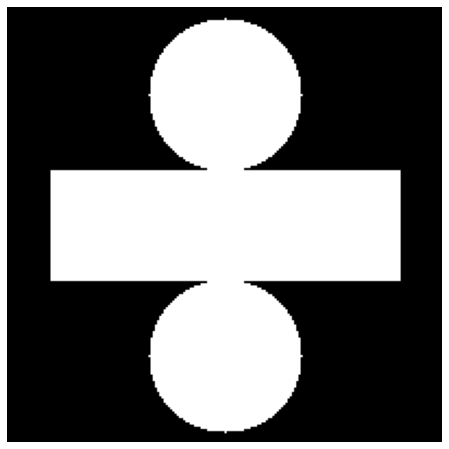

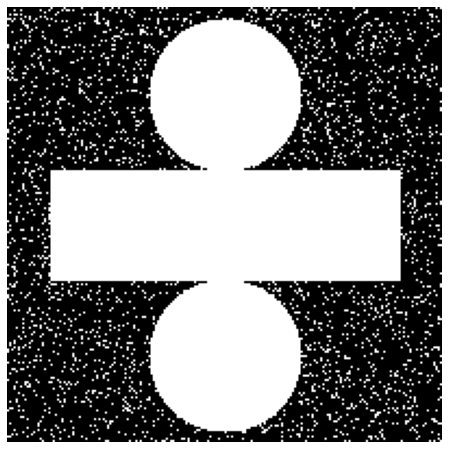

In [10]:
# Вывод: Исходное (из пункта 1), зашумленное (из пункта 2) и изображения после эрозии и дилатации.
print('Исходное изображение и зашумленное изображение')
show_me(img)
show_me(noise_image)

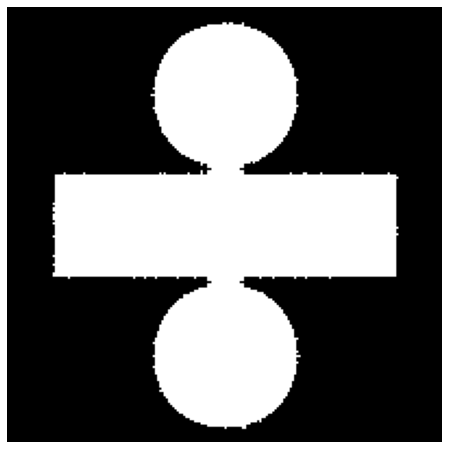

In [11]:
# Изображения после эрозии.
erosimg = eros(noise_image, сross)
show_me(erosimg)

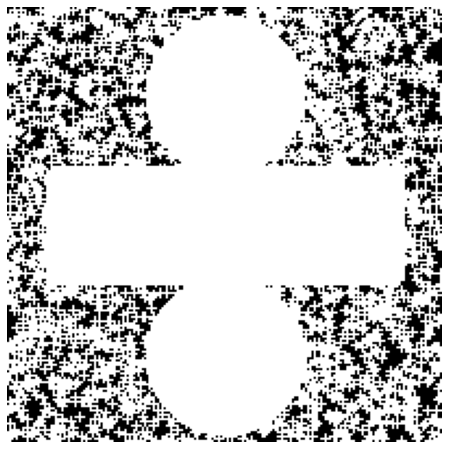

In [12]:
# Изображения после дилатации.
dilatimg = dilat(noise_image, сross)
show_me(dilatimg)

### 5. Отфильтровать зашумленное изображение при помощи морфологических операций вскрытия и закрытия (структурный элемент задан по вариантам).
Подсчитать коэффициент шума для результа фильтрации.

In [13]:
# количество несовпавших пикселей между отфильтрованным изображением и исходным

In [14]:
def opening(image, kernel): # Данная функция выполняет операцию вскрытия над исходным изображением
    return dilat(eros(image, kernel), kernel)
def closing(image, kernel): # Данная функция выполняет операцию закрытия над исходным изображением
    return eros(dilat(image, kernel), kernel)
def noise_factor(image1, image2): # Функция подсчета коэффициента шума
    return (np.sum(image1 != image2)/(image1.shape[0] * image1.shape[1])) * 100

Коэффициент шума в процентах:
0.0


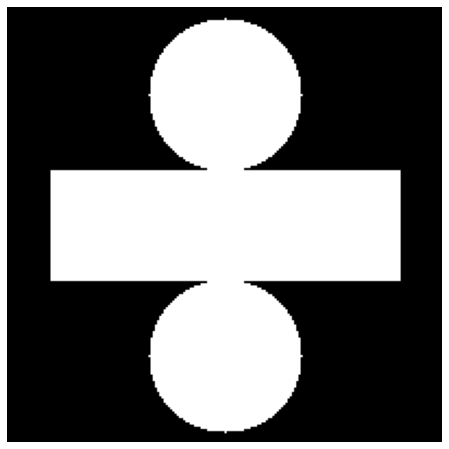

In [15]:
# Первоначаньное изображение (Тестируем)
show_me(img)
print("Коэффициент шума в процентах:")
print(noise_factor(img, img))

Коэффициент шума в процентах:
6.045


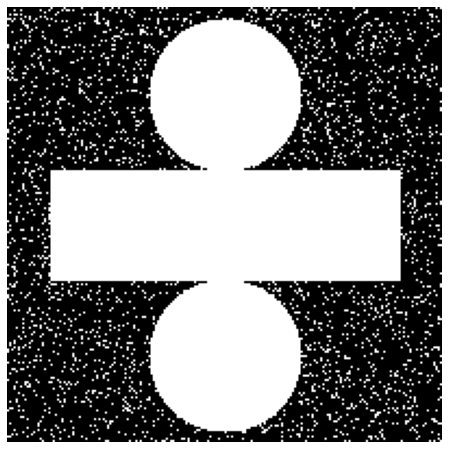

In [16]:
# Изображение с импульсным шумом
show_me(noise_image)
print("Коэффициент шума в процентах:")
print(round(noise_factor(img, noise_image),4))

Коэффициент шума в процентах:
0.2025


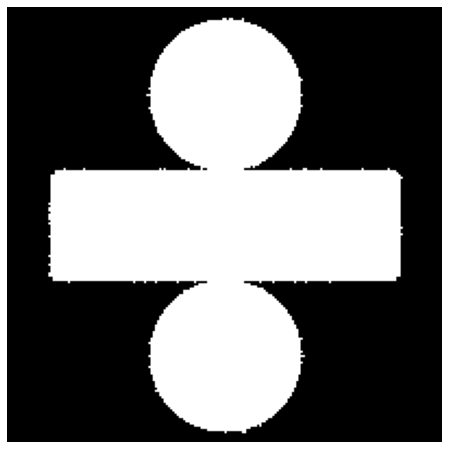

In [17]:
# Изоюражение после вскрытия
openimg = opening(noise_image, сross)

show_me(openimg)
print("Коэффициент шума в процентах:")
print(round(noise_factor(img, openimg),4))


Коэффициент шума в процентах:
9.2


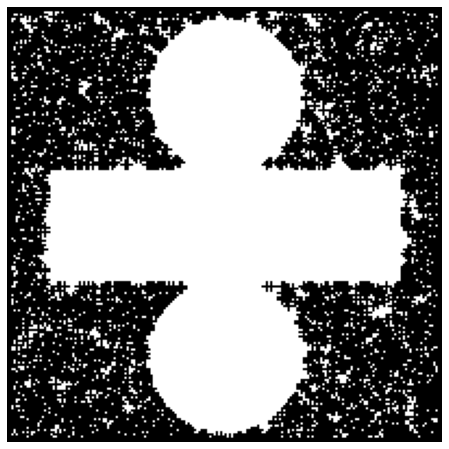

In [18]:
# Изоюражение после закрытия
closimg = closing(noise_image, сross)

show_me(closimg)
print("Коэффициент шума в процентах:")
print(round(noise_factor(img, closimg),4))

### 6. Отфильтровать изображение при помощи логического фильтра. Подсчитать коэффициент шума для результа фильтрации.

In [19]:
def value_filter(image, i, j): # Формирует значения для логического фильтра
    filter_value = image[i, j] and (image[i - 1, j] or image[i, j - 1] or image[i, j + 1] or image[i + 1, j]) \
        or (not image[i, j]) and (image[i - 1, j] and image[i, j - 1] and image[i, j + 1] and image[i + 1, j])
    return int(filter_value)

In [20]:
def logica(image): # Логический фильтр
    
    image_rows, image_cols = image.shape # Разсмерность
    output_image = np.copy(image) # Копируем
    
    # Временная картика с доп окнами (рамками)
    temp_image = np.zeros((image_rows + 2, image_cols + 2))
    temp_image[1: -1, 1: -1] = image
    temp_image = temp_image.astype(bool)

    for i, j in tqdm(np.ndindex((image_rows, image_cols))):
        output_image[i, j] = value_filter(temp_image, i, j)

    clear_output()
    return output_image

In [21]:
# Вывод: исходное (из пункта 1), зашумленное (из пункта 2) и отфильтрованное изображение. Коэффициент шума.

Коэффициент шума в процентах:
0.0


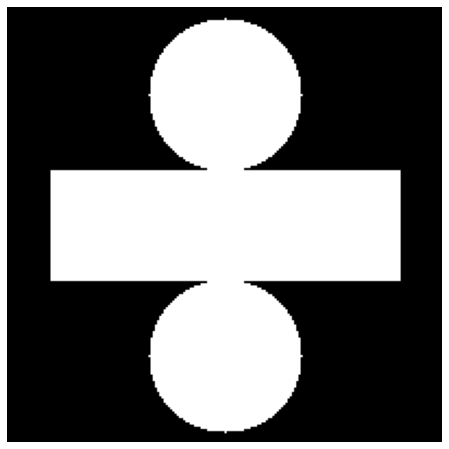

In [22]:
# Первоначаньное изображение (Тестируем)
show_me(img)
print("Коэффициент шума в процентах:")
print(noise_factor(img, img))

Коэффициент шума в процентах:
6.045


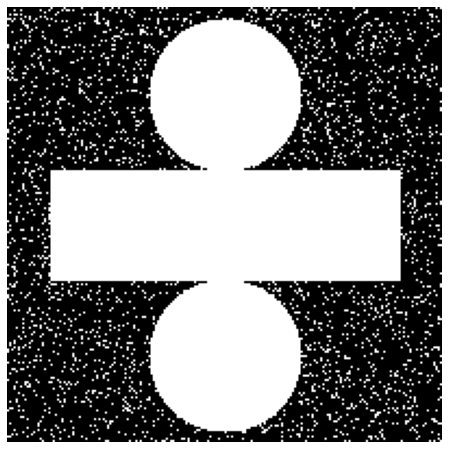

In [23]:
# Изображение с импульсным шумом
show_me(noise_image)
print("Коэффициент шума в процентах:")
print(round(noise_factor(img, noise_image),4))

Коэффициент шума в процентах:
42.7775


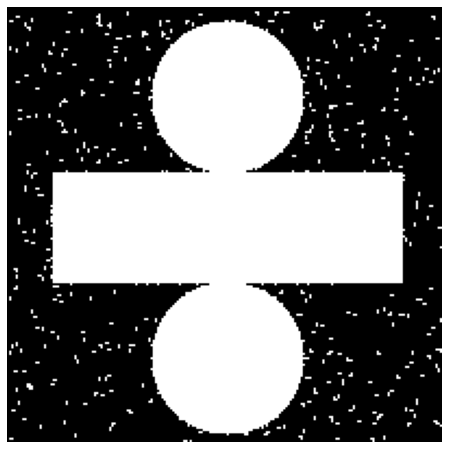

In [24]:
# Изображение после обработки логическим фильтром
logicimg = logica(noise_image)
show_me(logicimg)
print("Коэффициент шума в процентах:")
print(round(noise_factor(img, logicimg),4))

### 7. На исходном изображении с помощью морфологических операций выделить контур объекта. Выяснить, когда контур получается внешним, внутренним, четырёхсвязным, восьмисвязным.

In [25]:
# Вывод: исходное изображение, изображение с выделенными контурами.

In [26]:
outer = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
])
inner = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
])
four_connected = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1],
])
eight_connected = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
])

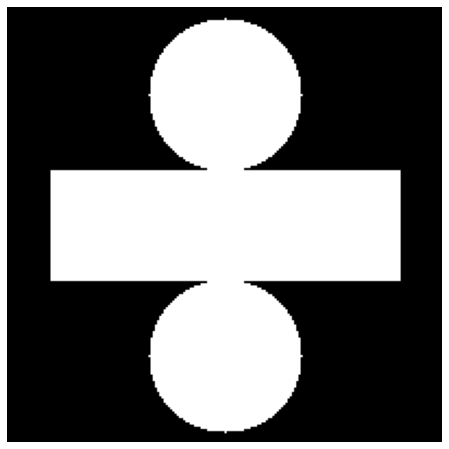

In [27]:
show_me(img)

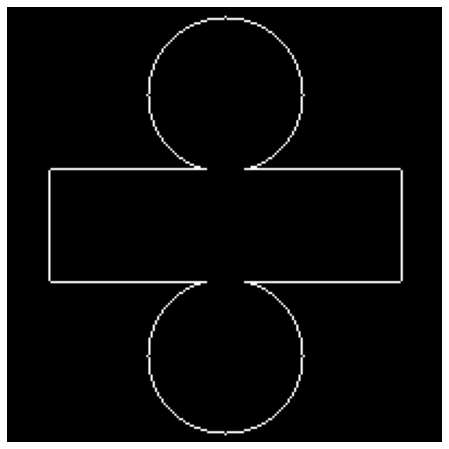

In [28]:
# Внешний контур
show_me((img ^ dilat(img, outer )))

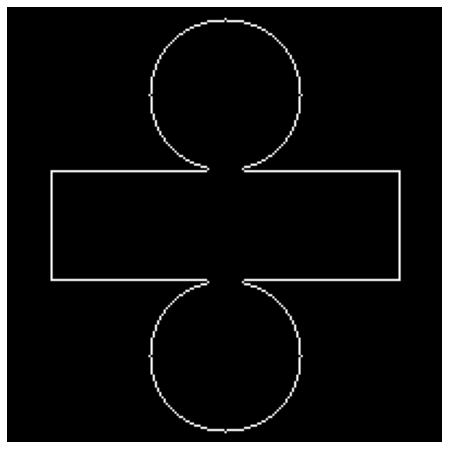

In [29]:
# Внутренний контур
show_me((img ^ eros(img, inner)))

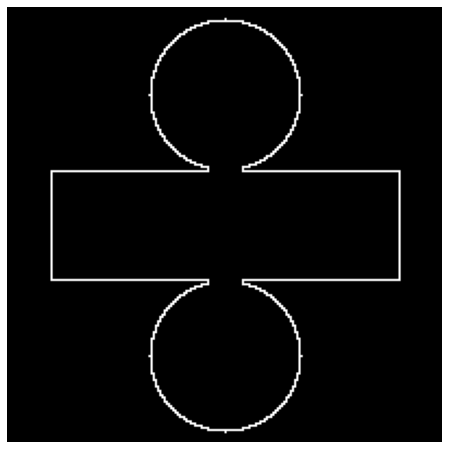

In [30]:
# Четырехсвязный внутренний контур
show_me((img ^ eros(img, four_connected)))

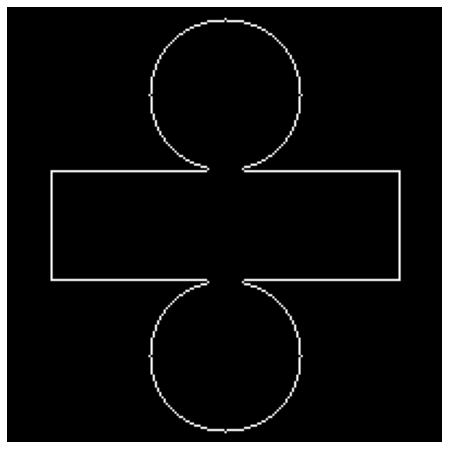

In [31]:
# Восьмисвязный внутренний контур
show_me((img ^ eros(img, eight_connected )))

### 8. На исходном изображении с помощью морфологических операций выделить горизонтальные и вертикальные контуры объекта.

In [32]:
# Вывод: исходное изображение, изображение с выделенными горизонтальными контурами,
# изображение с выделенными вертикальными контурами.

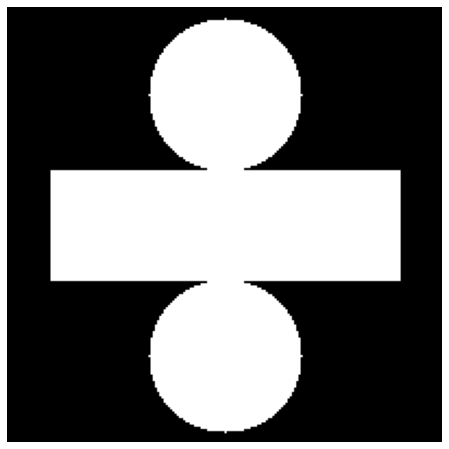

In [33]:
show_me(img)

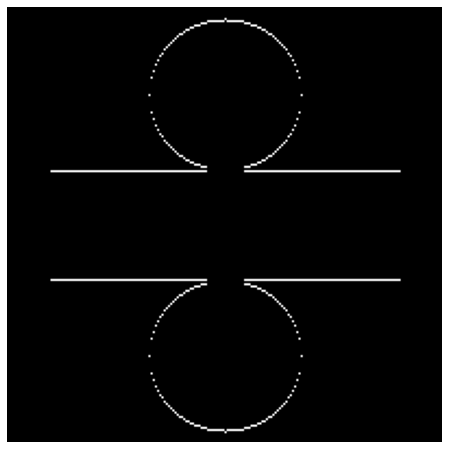

In [34]:
# C выделенными горизонтальными контурами
contours = np.array([ [1], [1], [1] ])
show_me((img ^ eros(img, contours)))

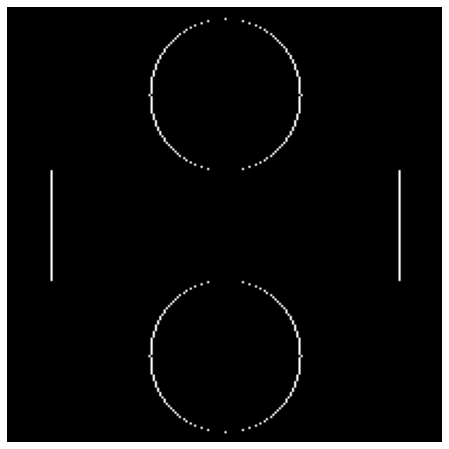

In [35]:
# C выделенными вертикальными контурами.
contours = np.array([ [1, 1, 1] ])
show_me((img ^ eros(img, contours)))